# RESTify Controlled Experiment Data Analysis

 > *Measuring the Software Engineering impact of a representative DSML toolchain.*

This Jupyter Notebook illustrates the design and results obtained throughout the McGill RESTify Controlled Experiment.
  * We summarize the experiment purpose and setup, then step by step take you through the interpretation of all data collected.
      * For more information about the recruitment process, visit the [RESTify Experiment Recruitment Page](https://www.cs.mcgill.ca/~mschie3/recruitment/).
  * Starting point for all analyses in this document is data automatically mined from study participant submissions.  The purpose of this document is the visualization and interpretation of statistical study data.
    * This input data was extracted from the raw participant submissions in a preliminary step. The corresponding details [are described in this document](#Measuring-Submission-Quality).
    * The section likewise contains references toward the tools needed for replication of the input data.

 > All statistical figures from our paper submission were created with this codebase. By running this Notebook, you validate our claims.

## Introduction

The RESTify controlled experiment involved 28 software developers, who each solved a state-of-the-art development task with two orthogonal methodologies. Namely, the interest of the experiment is to evaluate the effects of a DSML-centrist toolchain on specific software engineering qualities, by comparison to the established, legacy approach.
The remainder of this document is structured as follows:

 * [We describe a common, state-of-the-art refactoring task](#Task-and-Methodologies) and [define metrics that measure how well it was performed](#Metrics).
 * We then quantify and compare the quality of various task submissions, originating the outcome of several control groups. [The control groups were arranged](#Control-Groups) to pursue refactoring tasks using the DSML based toolchain and respectively manual code refactoring.
 * The main part is a statistical comparison of the measured submission qualities. This is the core contribution of this notebook, for it allows a transparent reproduction of our findings.
     * The Notebook allows local execution of the jupyter code cells, and hence independent replication of our results.
     * The referenced cell source code (hosted likewise in this directory) gives access to the raw data and implementations used, for convenient validation and reuse by the SE community.
 * The notebook concludes with an interpretation of the observed correlations.

The interest of this notebook centers on a fast and transparent replication of our statistical findings and claims. It extends the PDF article of our findings by the possibility to replicate our computations and verify a sane implementation of our metrics. For a contribution that focuses on a causal interpretation of these observations, we refer to a pending conference submission.

### Task and Methodologies

The aforementioned refactoring task is the conversion of legacy code to a RESTful service. Given the omnipresence of legacy systems and the continuously rising relevance of RESTful service based architectures, e.g. Microservice Architectures, this conversion is a recurring, state-of-the-art task with imminent industrial relevance.

#### Reference Context

We captured the refactoring challenge with two legacy systems, representing the e-commerce and gaming contexts frequently associated to RESTful services. Those are vanilla Java applications which express the core functionality of [a BookStore](https://github.com/m5c/BookStoreInternals/releases/tag/RestifyStudy) and [a Tic Tac Toe](https://github.com/m5c/XoxInternals/releases/tag/RestifyStudy) game logic.

In technical detail, the refactoring task was the conversion of the provided legacy sources to a RESTful service using the Spring Boot framework. Like most technical details of the experiment, Spring was selected because of its widespread industrial acceptance.

#### Methodologies

We considered two orthogonal methodologies for the refactoring task.

  * The classic, code-oriented approach: A software developer manually modifies the project's legacy sources for them to comply to a requested target behaviour. That is to say a developer loads the legacy project in their Integrated Developer Environment (IDE), integrates Spring Boot and exposes existing functionality over REST endpoints using Spring's annotation syntax.
  * The DSML-oriented approach: Legacy sources are examined by a modeling tool and their existing functionality is visualized. The developer then uses a tailored DSML to design the desired interface layout and graphically maps the produced REST endpoints to identified existing functionality. The modeling tool then generates the desired refactored source code.

 > The activity is performed in TouchCORE, an academic tool that provides a proof-of-concept implementation for the DSML-oriented approach. The details of how the DSML was integrated with the other languages TouchCORE are [described in an earlier publication](https://www.cs.mcgill.ca/~mschie3/contributions/FIDDLR.pdf).

Manual code refactoring is the widespread standard methodology for performing this task. However, lab internal experiments suggested that a DSML oriented approach can significantly outperform this manual methodology.
The RESTify controlled experiment was designed to gather the empirical data to test this hypothesis.

### Metrics

We considered two independent factors to measure the quality of the refactored solutions: *Speed* of task completion and *Correctness* of the outcome. These are fair metrics, as the success of industrial projects is likewise held to these standards.

  * In the context of our study, we consider *Speed* a normalized derivative of the time to task submission. That is to say the fastest participant scored a value of ```1``` and the slowest participant obtained a value of ```0```. The remaining participants received proportional scores in the range ```[0-1]```.
  * We define *Correctness* of a solution by means of compliance to a predefined interface and behaviour that observably reacts according to specification. Since the refactoring task mandates exposure of provided functionality through a defined REST interface, we can assess correctness [by automated, canonic tests of all individual interface endpoints](https://github.com/m5c/RestifyAnalyzer). The test passrate then provides a normalized notion for correctness, where ```1``` indicates full compliance to the expected interface, i.e. all tests pass. Solutions that do not pass any test receive a ```0```.

Among other factors e.g. bound costs and high maintainability, software projects altogether aspire a maximization of *Speed* and *Correctness*. We therefore define the overall quality of a submission as weighted sum of these factors. We decided to weight them equally, as the real-world weighting may vary from project to project.

The presented overall metric ranks solutions that were crafted quickly and that comply to the target interface close to ```1```, while the core for slow solutions showcasing significant discrepancy with the interface specification score tends toward ```0```.

## Experiment Setup

In this section we describe the efforts made to recruit a statistically sound population, including its partition into four representative groups. We hired a total of 28 software developers with various backgrounds, to mitigate the impact of outliers and cover the diverse spectrum of real-world software developer profiles.

We start by a statistical analysis of the skill sets found in the set of participants and then describe the methodology applied to divide them into comparable groups.

 > Note that in reality we encountered ongoing participant fluctuation, therefore recruitment took place in  iterations. The statistics shown in this document represent the final set of participants.

### Diversity

Recruitment included an auto-assessment of task related skills.

#### Self Assessment Form

Participants were asked to mark their proficiency on [a disseminated evaluation form](https://www.cs.mcgill.ca/~mschie3/recruitment/self-assessment.txt). For each of the 8 skill dimensions, we provided a textual metric that helped participants objectively quantify their skills on a scale of one to five.

Below example illustrates how we query proficiency for the singleton pattern:
```
How much do you know about the singleton pattern?
[ ] I don't know what it is.
[ ] I know what it is, but have never used it.
[ ] I have already used it in one of my projects.
[ ] I could verify a provided implementation.
[ ] I could implement it right away from scratch.
```

Participants were then asked to mark the most advanced option applicable.

#### Skill Analysis

We processed all participant self-declared skills and computed the resulting distribution.
The below cell replicates these computations and generates figures for the following statistics:

 * Sum of all declared skills, per participant (Mesh)
 * Proficiency in JAVA (Light Grey)
 * Proficiency with the Spring Framework (Mint)
 * Proficiency with the Build-System Maven (Light Blue)
 * Knowledge about the Modeling Tool TouchCORE (Deep Purple)
 * Proficiency with the UNIX/OS command line (Pink)
 * Knowledge about the REST networking paradigm (Red)
 * Knowledge about the Singleton pattern (Orange)
 * Knowledge about Reflection in programming languages (Dark Grey)

 > Note that the above colour scheme for individual skills is maintained for the remainder of this document.

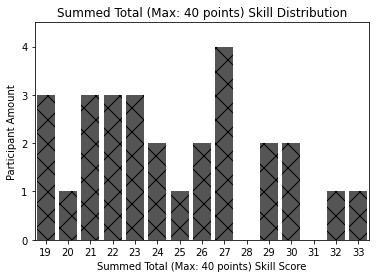

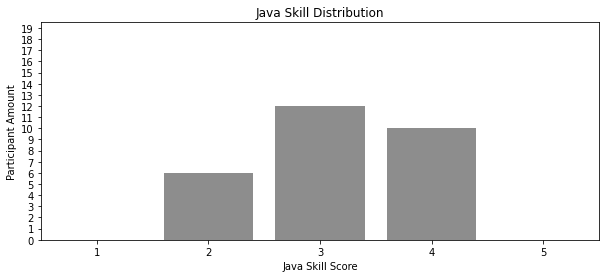

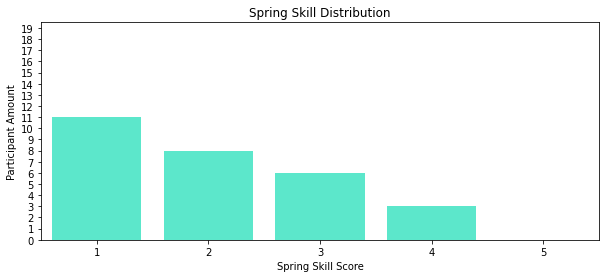

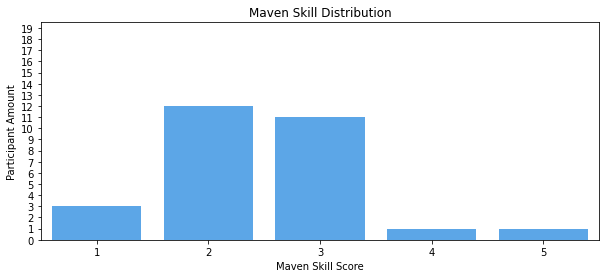

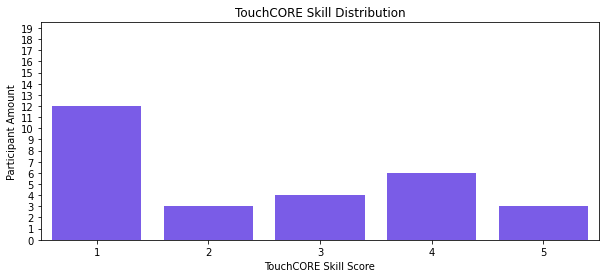

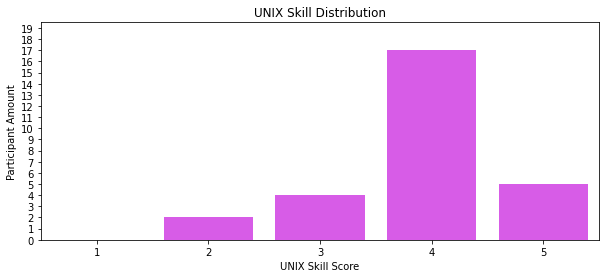

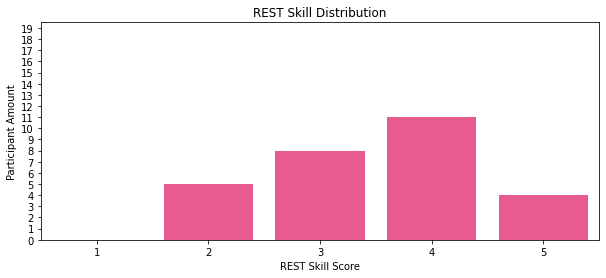

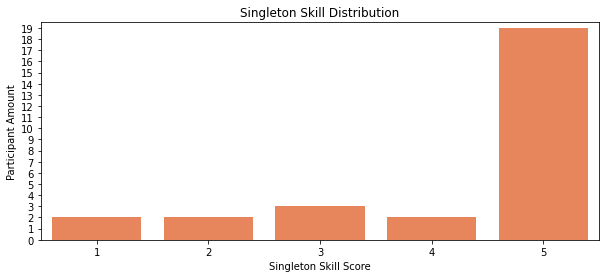

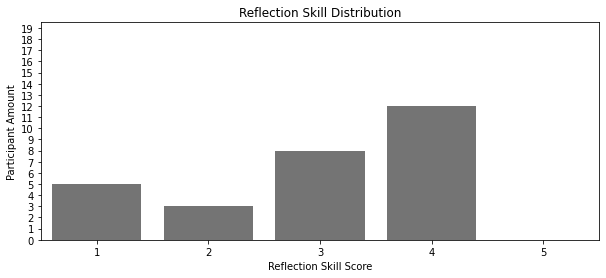

In [1]:

from jupyter_snippets.pseudo_cell_01_display_population_skill_stats import cell_01

cell_01()

#### Interpretation

We acknowledge the extracted distributions vary by skill. Yet we also observe a strong diversity in the population, which we deem a positive factor toward the expriment's robustness.
We also recognize that the profiles remain a self-declared assessment, and by nature is prone to subjective biases due to false estimations of the own skills.
In case of the participant who scored best, we also suspect at least one upfront dishonest declaration, where the associated participant performed extremely poor. We believe the participant had no interest in actual task solving and targeted uniquely the 100 Canadian Dollar gift card issued to participants as compensation. The participant is marked as outlier wherever applicable.

### Control Groups

The purpose of the experiment was a comparison of the two aforementioned methodologies, regarding task solving effects. However, to ensure fairness, we could not simply ask each participant to first refactor using *Methodology A*, followed by refactoring the same application with *Methodology B*, as there are multiple potential learning affects to consider:

  * Learning effect from the application context: The first and the second task should not concern the same codebase. We eliminated this effect by alternating between two representative refactoring contexts of comparable complexity:
    * The BookStore, a vanilla e-commerce application representing assortment, comments and stock information for a book vendor.
    * Xox, a vanilla board game application representing an action oriented implementation of Tic Tac Toe.
  * Potentially unfair advantage due to the application or methodology order:
    * Half the population should begin with *Application 1*, the other half should start with *Application 2*.
    * Half the population should begin with *Methodology A*, while the remainder should begin with *Methodology B*

We decided to divide the population into four control groups (*Red*, *Green*, *Blue* and *Yellow)* with different task methodology and context order. This setup showcases several advantages:

  * Statistical observations on the full population automatically level out any potential advantages from a specific order, as we hold the equal participant amount for either variant.
  * We can assess the effects of a specific task order, methodology or contextual combination, by comparison of the corresponding control group to the remaining population.

The below figure illustrates the effective task orders for the individual control groups:
<div>
<img src="static-figures/salad.png" width="360"/>
</div>

TODO: change methodology enumeration to roman letters in figure.

The red square labelled "1" indicates the task details for the first refactoring task of the red control group. In this case it lies in the first quadrant, meaning participants were asked to refactor *Application 1 / E-Commerce* (the BookStore), using *Methodology A / MDE* (The DSML approach with TouchCORE). Similar the red square labelled "2" indicates a task where *Application 2 / Boar Game* (Tic Tac Toe) must be refactored using *Methodology B* (IDE on the example of IntelliJ).

 > Whatever the control group, all task sequences lie on a main diagonals. Furthermore, every group has a symmetric counterpart to offset learning effects in statistics for the full population.

#### Finding a fair partition

Although the above partition into complementary control groups offsets learning effects, experiment fairness also depends on a fair group repartition. That is to say the individual control groups must be comparable in terms of their skill profiles.
For instance, we want to avoid any situation where all participants which high technical proficiency end up in one control group and while complementary participants with profound experience are gathered in another.

We deem the total population size of 28 insufficient to purely rely on stochastic balancing effects. We therefore implemented an algorithm to search for an optimized participant repartition.
While the population is still too large to test all potential combinations for viability, we were able to implement [a MiniMax heuristic, that is to say an algorithm that iteratively works toward a viable repartition by minimizing what hinders comparability](https://en.wikipedia.org/wiki/Minimax). Namely, we searched to minimize the maximum distance in average skill proficiency between two control groups. The fully documented sources of our partition algorithm are [publicly available](https://github.com/m5c/RecruitmentFormInterpreter).
Tho software also allows brute force testing force placement of replacement participants, which was unfortunately necessary, as recruited participants repeatedly retracted from the study, or ceased any form of communicated, even after a fraction of the results was already collected. We decided for recruitment iterations, searching optimal replacement allocations of multiple participants, to mitigate the effects of changing skill profiles between original participant and replacement.

The below boxplot shows the effective comparability of the final stable population. Every skill is represented by a series of four coloured boxplots, where each plot represents one control group. Ideally we would see the exact boxplot for each control group, that is to say equal mean (represented by a square) and equal distribution (represented by the whiskers).



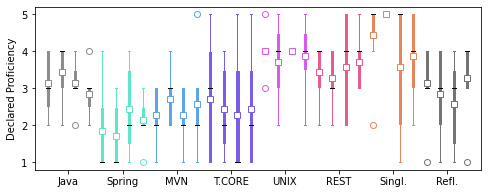

In [2]:
from jupyter_snippets.pseudo_cell_02_display_cgroups_skill_boxplot import cell_02

cell_02()

We acknowledge that the above repartition is fair, yet not optimal. That is to say there would have been partitions that perform better under the metric applied. To some extent this results from the heuristic implemented, which iteratively optimizes the MiniMax, without testing all possible partitions. However, a greater factor is the replacement of unreliable participants by replacements with distinct profiles.

Below computation quantifies overall "*threat*" to control group comparability, under the applied metric. The listing shows the average minimum and maximum skill value for any pair of control groups and any skill. The MiniMax heuristic attempted to keep the greatest offset, between any such two values as low as possible.

In [3]:
from jupyter_snippets.pseudo_cell_04_compute_cgroup_skill_diffs import cell_04
from jupyter_snippets.pseudo_cell_03_merge_csvs import cell_03

cell_03()
cell_04()

<_io.TextIOWrapper name='source-csv-files/skills.csv' mode='r' encoding='utf-8'>
Control group comparability analysis. Listing of the greatest differences (average skill values) between any pairs of control groups:
Java	: 	AVG_MIN=2.9,	AVG_MAX=, 3.4,	MAX_AVG_DIFF=0.6
Spring	: 	AVG_MIN=1.7,	AVG_MAX=, 2.4,	MAX_AVG_DIFF=0.7
MVN	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
T.CORE	: 	AVG_MIN=2.3,	AVG_MAX=, 2.7,	MAX_AVG_DIFF=0.4
UNIX	: 	AVG_MIN=3.7,	AVG_MAX=, 4.0,	MAX_AVG_DIFF=0.3
REST	: 	AVG_MIN=3.3,	AVG_MAX=, 3.7,	MAX_AVG_DIFF=0.4
Singl.	: 	AVG_MIN=3.6,	AVG_MAX=, 5.0,	MAX_AVG_DIFF=1.4
Refl.	: 	AVG_MIN=2.6,	AVG_MAX=, 3.3,	MAX_AVG_DIFF=0.7
--------------
The worst difference in average skill values between two control groups in the given partition appears for:
	"Singleton", with a difference of 1.4


The greatest offset observed stems from a maximum average skill of ```5.0``` for the singleton pattern (the second and highest orange box in boxplot), compared to an average value of ```3.6``` (the lowest orange box in boxplot). This offset defines the largest difference in terms of average skill offset between two control groups, resulting in an offset of ```1.4``` points on a scale of 1-5.

Although not optimal, we conclude from the above computation that the obtained repartition showcases a sufficient similarity in skill diversity and distribution to allow for a meaningful analysis of the experiment outcome.

# Measuring Submission Quality

The weighted sum of normalized refactoring time and submission correctness requires raw data on time to task completion, and normalized test pass rates for every participant. In the next section we describe how we obtained this data, and assess to which extent it is replicable.

## Measuring Time

We recorded the entire task-relevant activity on screen. Summing up the footage of all participants, we collected a total of 72 hours of video material.
We carefully viewed all recordings to measure the effective time spent on task familiarization and completion. The distinction was made as follows: For each task, we asked participants to watch a instruction video. This video illustrates the task methodology on exemplary, non task related application: [The zoo](https://github.com/m5c/Zoo). For every participant, we quantified the time in seconds spent on this task familiarization. We noticed that the measured time would greatly vary, because some participants replicated all demonstrated steps, using the test application, before proceeding to their actual task.
Additionally, the video footage revealed several factors that impact the measurements:

  * Participants used varying playback speed to consume the video instructions.
  * Participants watched the material non-linear, i.e. replaying a specific passage several times or fast forwarding through parts they deem redundant.
  * Participants did not always respect the requested order, that is to say there were cases where a participant would interleave video instructions and own task solving.

We manually extracted time markers, which indicate transitions between the above phases and then used [a custom converter tool](https://github.com/m5c/TimeDiffCalc) to produce the overall time per phase in seconds.
This was especially useful for participants who interleaved instructions and task solving. The listing below shows the ongoing analysis for a participant (*Green Squid*), who frequently alternated between the phases in a matter of minutes and sometimes seconds.

```
Start: 00:01:25 End: 00:02:27 Offset: 00 Diff: 62 [00:01:02]
Start: 00:02:57 End: 00:04:55 Offset: 62 Diff: 180 [00:03:00]
Start: 00:05:22 End: 00:07:10 Offset: 180 Diff: 288 [00:04:48]
Start: 00:08:15 End: 00:08:52 Offset: 288 Diff: 325 [00:05:25]
...
...
...
Start: 02:40:13 End: 02:40:32 Offset: 3025 Diff: 3044 [00:50:44]
Start: 02:46:18 End: 02:47:15 Offset: 3044 Diff: 3101 [00:51:41]
```

We likewise extracted the effective time in seconds for task solving, by cumulating the markers for task-related on screen activity.
The outcome of the described activity are four values per participant, each indicating a duration in seconds:

  * Time spent on preparation of manual task.
  * Time spent on solving manual task solving.
  * Time spent on preparation of model assisted task.
  * Time spent on solving model assisted task.

We will interpret the findings throughout the remainder of this notebook. The raw values are available as CSV file in the [source csv files](source-csv-files/time.csv) directory.

### Reproducibility

We cannot release the original on-screen recordings, as it would break participant anonymity. While participants were instructed to conceal all personal information, the collected video material showcases personal identifiers in abundance, e.g. user profiles on websites, OS menubar and open email inboxes. This effectively means the extracted markers and resulting durations are not replicable to anyone outside the study.

For transparency, we do however provide a detailed transcript of on-screen activity, as part of the [duration CSV file](source-csv-files/time.csv). The noted observations are coherent to the observed durations. Where applicable we will cite from the transcript, to reason about analysis outliers.

## Measuring Submission Correctness

We measured correctness of the submitted solutions by testing against the provided interface specification. More precisely, we compiled and deployed every produced RESTful service and compared the HTTP responses to our test probes to the expected return.
Given the amount of submissions and API endpoints to test, we [implemented a custom test tool](https://github.com/m5c/RestifyAnalyzer), to reliably assess the total of 560 endpoints. Yet the choice was not uniquely made based on the workload.

We also implemented our own testing tool, to better encounter a paradox requirement associated to the applications' stateful nature:
1) Tests must not be dependent, since otherwise a failed test can produce false-negatives for subsequent tests. E.g. if we fail to create a game instance in the Tic Tac Toe backend, necessarily all subsequent calls that interact with the instance must fail, even if their submitted implementation is correct.
2) Tests cannot be independent, since the effectiveness of any state-altering operation needs verification by a subsequent lookup call.

We were able to mitigate the above conflict with the following measures:

 * The test applications are seeded with deterministic state, which fully resets on deployment. This detail of the original implementation allows a programmatic state reset, between any two test probes sent. The overhead is significant, as a full redeploy takes several seconds. Yet we consider this the safest way to eliminate any false-negatives of category 1.
  * All tests for write operations are effectuated twice: Once with subsequent read verification, and once without. Comparison of the outcome delimits the scope of the error, in case of a test failure to few instances, where we ultimately inspected the implementation details manually.

### Reproducibility

The testing results are fully reproducible. We inspected and deprived the participant submissions of all identifiers and [prepared a source code bundle for public download](https://www.cs.mcgill.ca/~mschie3/restify/submissions).
We likewise provide the testing tool, alongside with detailed run instructions as [open source project on GitHub](https://github.com/m5c/RestifyAnalyzer).
Anyone can clone the test tool and re-assess the provided submissions to obtain the [same test report CSV](source-csv-files/tests.csv).


# Fused CSV

Note that to facilitate further research by peers we also added a cell to fuse the multiple raw CSV files into a single file. The output is generated to ```generated-csv-files/```


In [4]:
from jupyter_snippets.pseudo_cell_03_merge_csvs import cell_03

cell_03()


<_io.TextIOWrapper name='source-csv-files/skills.csv' mode='r' encoding='utf-8'>


# Data Analysis

We now run various statistic tests and produce plots from the previous data. All statistic figures and listings from our paper submission can be replicate by executing the below cells.


## Submission Correctness

We begin by assessing the correctness of the submitted participant code.
The first cell creates a map, where rows are participants (of the four control groups, and columns individual tests. Black squares indicate a failed test, coloured squares indicate success:

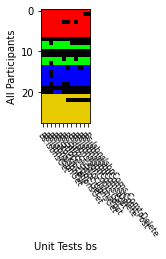

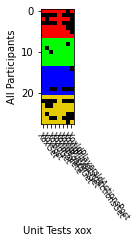

In [5]:
from jupyter_snippets.pseudo_cell_05_all_results_all_participants import cell_05

cell_05()

The same information can be displayed as a heatmap, where darker regions indicate that a group performed on average worse and brighter cells indicate an on average higher pass rate.
We create two heatmaps, on for each applciation.


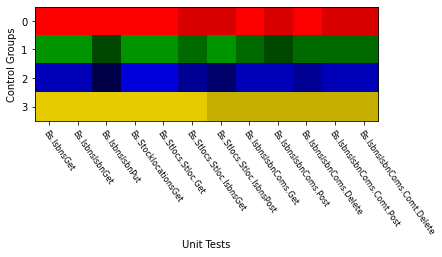

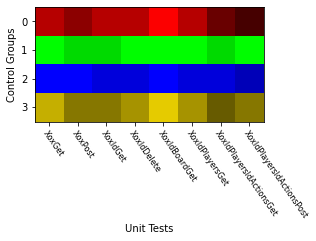

In [6]:
from jupyter_snippets.pseudo_cell_07_all_tests_all_groups import cell_07

cell_07()

If we want a different representation that allows for an easier comparison of the respective groups, we can represent the same data as radar charts. Every contour represents the average test pass ratio of a control group, the radiants represent individual tests. We note that always a pair of groups encompasses another pair of groups, which is a first indicator for the different group performances, depending on the conversion methodology applied for the task:


Radar numeric values for xox:
Red test average passrates: [0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0, 0.7142857142857143, 0.42857142857142855, 0.2857142857142857]
Red overall average: 0.6428571428571429
Green test average passrates: [1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0]
Green overall average: 0.9464285714285714
Blue test average passrates: [1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143]
Blue overall average: 0.8928571428571428
Yellow test average passrates: [0.8571428571428571, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 1.0, 0.7142857142857143, 0.42857142857142855, 0.5714285714285714]
Yellow overall average: 0.6785714285714285


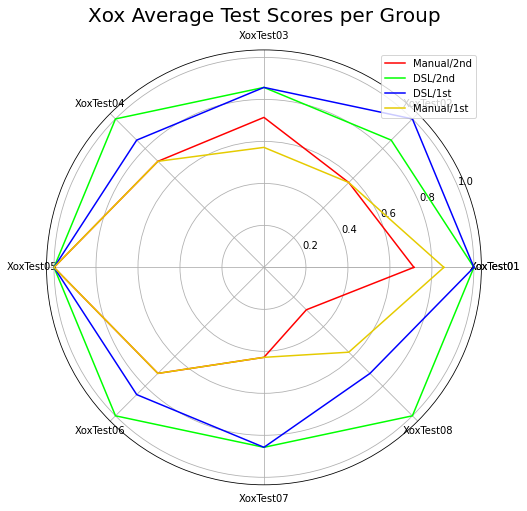

Radar numeric values for bs:
Red test average passrates: [1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571]
Red overall average: 0.9404761904761906
Green test average passrates: [0.5714285714285714, 0.5714285714285714, 0.2857142857142857, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.5714285714285714, 0.42857142857142855, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855]
Green overall average: 0.46428571428571436
Blue test average passrates: [0.7142857142857143, 0.7142857142857143, 0.2857142857142857, 0.8571428571428571, 0.8571428571428571, 0.5714285714285714, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143]
Blue overall average: 0.6547619047619048
Yellow test average passrates: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.857142857142

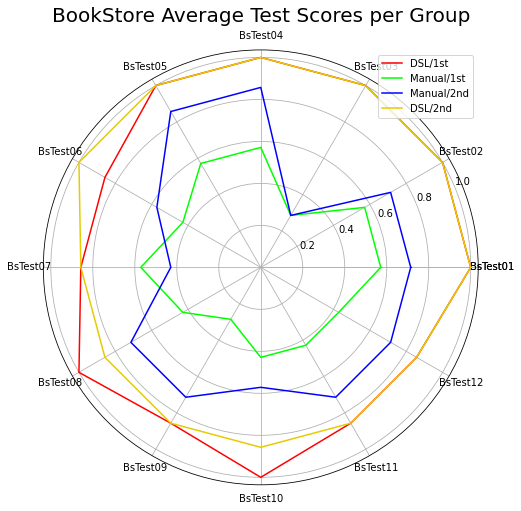

In [7]:
from jupyter_snippets.pseudo_cell_06_all_results_all_groups_radar import cell_06
cell_06()

## Conversion Time

We are not only interested in the correctness of collected submissions, but also want to know hoe long it took participants to produce the submissions. We analyzed 72h of video material to extract the effective time participants spent on task preparation and task solving. The following boxplot indicates the pure conversion task time distributions for all groups and all conversion tasks,as well as the numeric time in seconds for group averages.


Conversion time for ide task, red/green/blue/yellow in seconds: 
2407.8571428571427
5618.0
4166.428571428572
3355.0
Conversion time for tc task, red/green/blue/yellow in seconds: 
1846.7142857142858
2261.0
2641.5714285714284
2215.285714285714


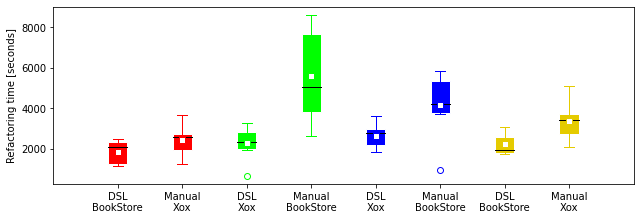

In [8]:
from jupyter_snippets.pseudo_cell_09_time_boxplot import cell_09

cell_09()

# Scatter Relations

Next we put all previous findings into correlation, by creating series of scatters. Every dot represents one participant. In every scatter series we inspect a different aspect for potential correlation.

 > Keep in mind that this notebook is a starting point for replication of our statistical analysis, not so much of the interpretations. Please see the paper submission for an evaluation and discussion.

We begin by assessing whether the task execution time depends on the time spent on task familiarization:

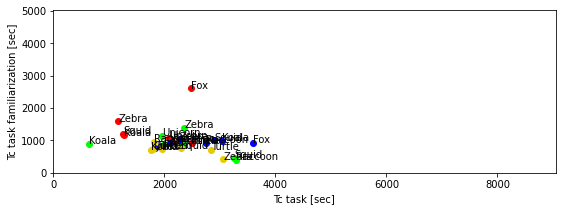

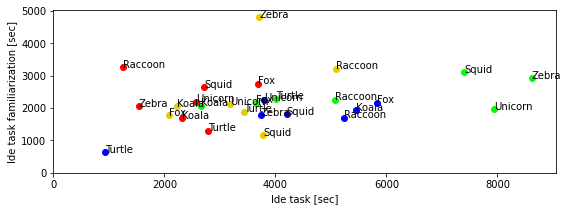

In [9]:
from jupyter_snippets.pseudo_cell_10_pretime_time_scatter import cell_10
cell_10()

Next we inspect if there is a visual correlation between time spent on a task and the correctness of the outcome.


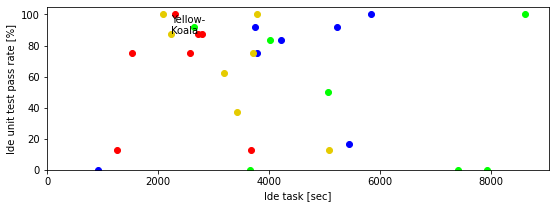

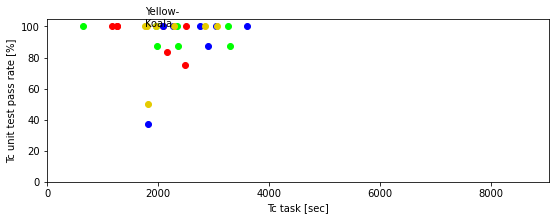

In [10]:
from jupyter_snippets.pseudo_cell_11_time_passrate_scatter import cell_11

cell_11()

Next we are interested in a potential correlation of time spent on task familiariation and submission correctness:


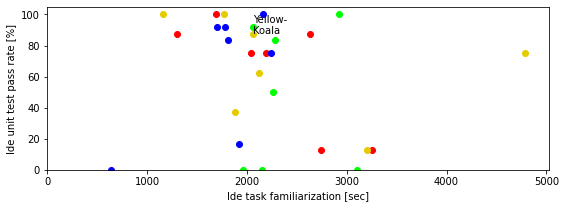

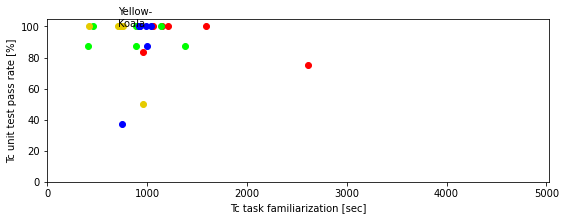

In [11]:
from jupyter_snippets.pseudo_cell_12_pretime_passrate_scatter import cell_12

cell_12()

We also analyze the effects of participants skill scores on the converted software correctness, regardless of the application refactored or methodology used:

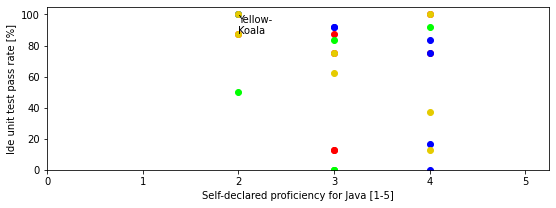

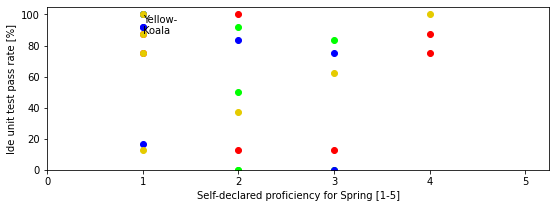

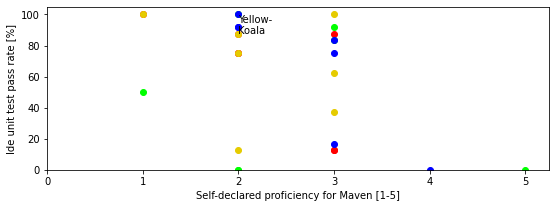

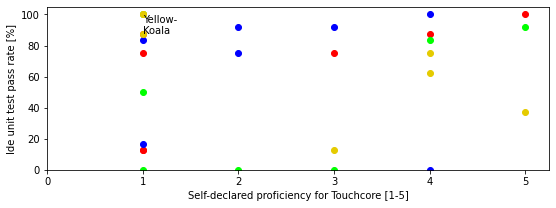

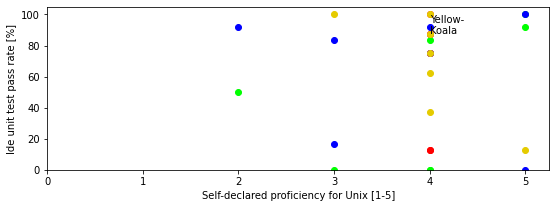

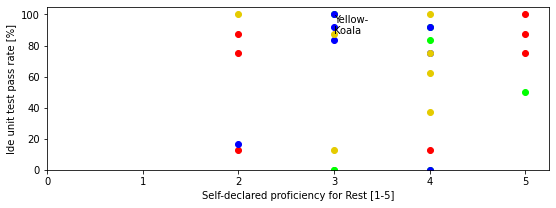

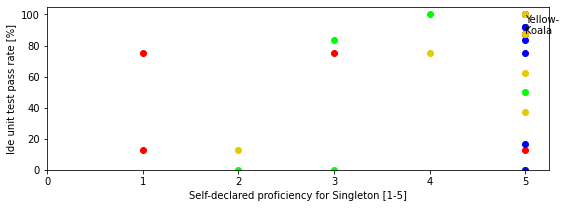

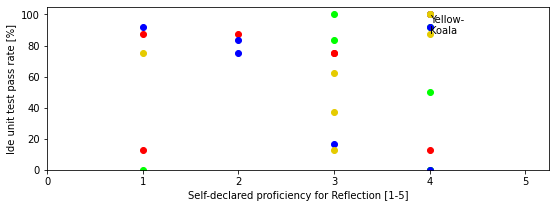

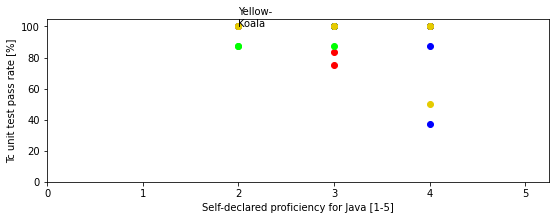

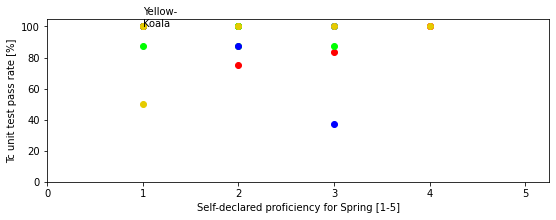

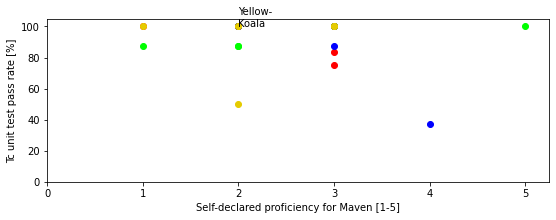

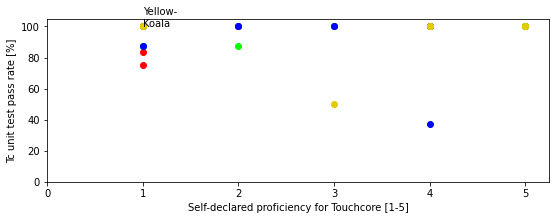

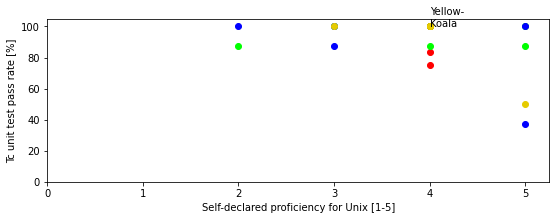

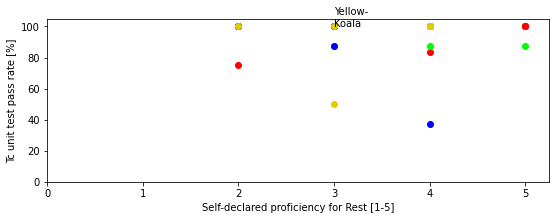

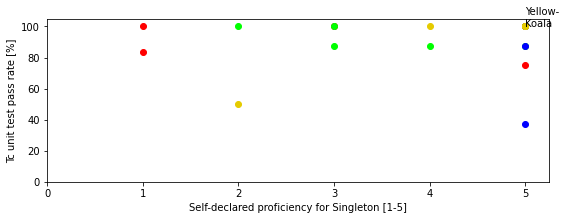

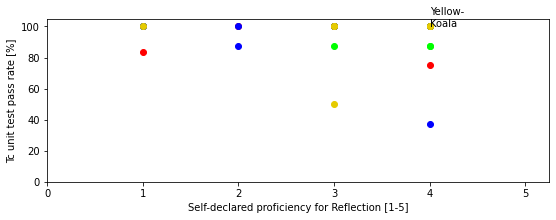

In [12]:
from jupyter_snippets.pseudo_cell_13_skill_passrate_scatter import cell_13

cell_13()


The following scatters also run a test for linear correlation, the Pearson test.

We begin with a suspected impact of the participants overall skill on the measured correctness of the produced solution:


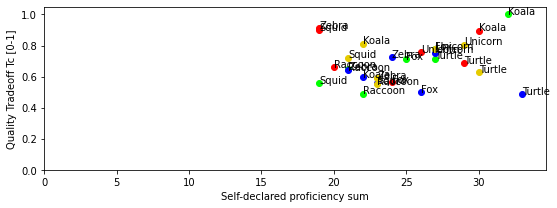

Pearson test for linear correlation between submission quality (tradeoff) and participant skills, tc:
PearsonRResult(statistic=0.14402869676202262, pvalue=0.4646528196133783)
Note: Linear correlation result ("statistic") is only significant if "pvalue" is smaller than 0.05


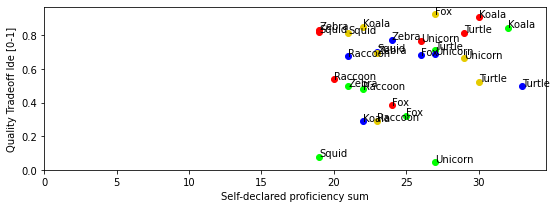

Pearson test for linear correlation between submission quality (tradeoff) and participant skills, ide:
PearsonRResult(statistic=0.16229761024314937, pvalue=0.4092947894668858)
Note: Linear correlation result ("statistic") is only significant if "pvalue" is smaller than 0.05


In [13]:
from jupyter_snippets.pseudo_cell_17_skill_quality_by_methodology_scatter_pearson import cell_17

cell_17()

There is a slight correlation, but the pearson test rejects it, as it is not statistically
if significant

Next we investigate if more time spent on task preparation leads to a measurable higher correctness of the outcome. We likewise perform a Pearson test for linear correlation:


In [14]:
from jupyter_snippets.pseudo_cell_18_pretime_quality_by_methodology_scatter_pearson import cell_18

cell_18()

Pearson test for linear correlation between submission quality (tradeoff) and methodology pre-time, tc:
PearsonRResult(statistic=0.13651185999354623, pvalue=0.48851498985262365)
Note: Linear correlation result ("statistic") is only significant if "pvalue" is smaller than 0.05
Pearson test for linear correlation between submission quality (tradeoff) and methodology pre-time, ide:
PearsonRResult(statistic=-0.2493450754295911, pvalue=0.200692959674856)
Note: Linear correlation result ("statistic") is only significant if "pvalue" is smaller than 0.05


Likewise, we find no statistically significant correlation.

## Normal Distributions

We would now like to visualize the weighted sum performance (conisiting of normalized converion time needed and normalized correctness of the solution). We therefore compute the normalized score per participant, and then visualize the resulting distributions per groups with same application and methodology. These are represented as solid orange and turquoise lines.

The cell likewise performs a Shaprio Wilk test to assess if these Samples are legit to be displayed as Normal Distributions:


------
p-value for Green Blue Normalized xox Quality Tradeoff: 0.9682269096374512
Cannot reject Null-Hypothesis. Found no evidence to assume the samples could not come from a normal distribution.
------
p-value for Red Yellow Normalized xox Quality Tradeoff: 0.11898528039455414
Cannot reject Null-Hypothesis. Found no evidence to assume the samples could not come from a normal distribution.
Normal distribution data for xox
Green/Blue Mean xox: 0.7564987201777261
Red/Yellow Mean xox: 0.5785621719952349
Green/Blue Standard Deviation xox: 0.10465870950678781
Red/Yellow Standard Deviation xox: 0.2208115670162124
Wilcoxon for xox
RanksumsResult(statistic=2.251436323159369, pvalue=0.02435791571803699)


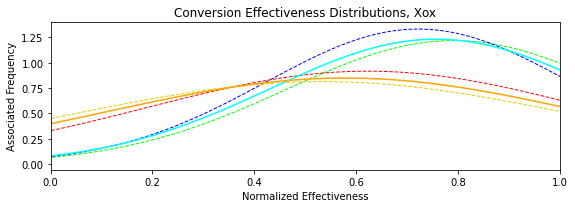

------
p-value for Green Blue Normalized bookstore Quality Tradeoff: 0.11543134599924088
Cannot reject Null-Hypothesis. Found no evidence to assume the samples could not come from a normal distribution.
------
p-value for Red Yellow Normalized bookstore Quality Tradeoff: 0.07292808592319489
Cannot reject Null-Hypothesis. Found no evidence to assume the samples could not come from a normal distribution.
Normal distribution data for bookstore
Green/Blue Mean bookstore: 0.521847072812738
Red/Yellow Mean bookstore: 0.8954060067257492
Green/Blue Standard Deviation bookstore: 0.2446704994007547
Red/Yellow Standard Deviation bookstore: 0.08020741258163075
Wilcoxon for bookstore
RanksumsResult(statistic=-4.1812388858673994, pvalue=2.8992506445686264e-05)


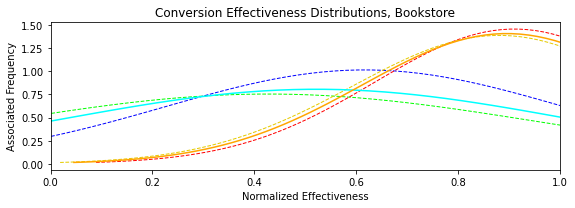

In [15]:
from jupyter_snippets.pseudo_cell_15_qualitytradeoff_by_app import cell_15

cell_15()

# Participant Feedback

In this last section we evaluate the feedback provided by participants, to create a barchart. It puts into relation the amount of participants who preferred the DSL tool, were neutral, or are more positive toward the manual project conversion technique, for three questions:


[26, 1, 1]
[15, 1, 13]
[7, 5, 16]


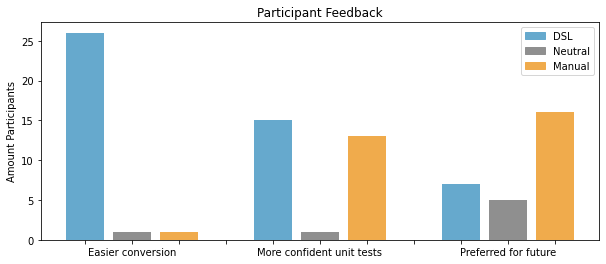

In [16]:
from jupyter_snippets.pseudo_cell_19_participant_feedback import cell_19

cell_19()